In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment, EnvironmentMeanField
from src.runner import runner, runner_mean_field
from src.helpers import confidence_interval
from sklearn import preprocessing
import random
import json
import geopy.distance

In [16]:
style.use('seaborn-white')

# Setting the parameters

In [17]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [18]:
TIME = 120

In [19]:
parameters = {
    # general simulation parameters
    "time": TIME,
    "number_of_agents": 1000,
    "monte_carlo_runs": 1,
    
    # Cape Town specific parameters
    "foreign_infection_days": [x for x in range(0, 19)], # total agents infected in CT
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    
    # non determinable parameter
    "percentage_contacts_recurring": 0.95,
    
    # COVID-19 parameters
    "exposed_days": 4, # average number of days without symptoms and being able to infect others
    "asymptom_days": 10, # average number of days agents are infected but do not have symptoms
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "probability_transmission": 0.02, # should be estimated to replicate realistic R0 number.
    "probability_symptomatic": 0.75, # determines whether an agent will become asymptomatic or asymptomatic spreader
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    
    # Policy parameters
    "lockdown_days" : [0 for x in range(0, TIME)], # in the baseline this is 0, 5 march was the first reported case, 27 march was the start of the lockdown 35 days 
    "informality_dummy": 1.0, # setting this parameter at 0 will mean the lockdown is equally effective anywhere, alternative = 1
    
    # Specific policy parameters
    # (1) physical distancing measures such as increased hygiëne & face mask adoption 
    "physical_distancing_multiplier": 0.27, # Jarvis et al. 2020,
    # (2) reducing travel e.g. by reducing it for work, school or all
    "travel_restrictions_multiplier": {key:value for key, value in zip(age_groups, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])}
    "visiting_recurring_contacts_multiplier": 0.8, # depending on how strict the lockdown is at keeping you put.
    # (4) Testing and general awareness
    'likelihood_awareness': 0.2, # this will be increased through track & trace and coviid
    'self_isolation_multiplier': 0.4, # determines the percentage of connections cut thanks to self-isoluation can go up with coviid
    'aware_status': ['i2'], # i1 can be added if there is large scale testing 
    # (5) limiting mass contact e.g. forbidding large events
    "gathering_max_contacts": 4,
    
    # Technical parameters
    'init_infected_agent': 0, # to calculate R0
    "data_output": 'csv', # 'csv' or 'network', or 'False'
    
    # Depreciated paramters (can be used later)
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    
}

Store parameters in JSON file.

In [20]:
with open('parameters/parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

In [21]:
# load parameters
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

# Generate district data using Ward data from Cape Town

Take into account informality of the different districts.

In [8]:
inital_infections = pd.read_csv('input_data/Cases_With_Subdistricts.csv', index_col=0)

In [9]:
informal_residential = pd.read_csv('input_data/Informal_Residential.csv').iloc[:-1]

In [10]:
# Create x, where x the 'scores' column's values as floats
x = informal_residential[['Informal_residential']].values.astype(float)

# # Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# # Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# # Run the normalizer on the dataframe
informal_residential['Informal_residential'] = pd.DataFrame(x_scaled)

In [11]:
population = pd.read_csv('input_data/population.csv')

In [12]:
population['Informal_residential'] = informal_residential['Informal_residential']

In [13]:
population.head(3)

,WardID,Population,Area,Density,lon,lat,Informal_residential
0,19100001,26434.07345,27213.359916,0.971364,18.612025,-33.857307,0.0
1,19100002,29914.18993,9222.458013,3.243624,18.422324,-34.069837,0.0
2,19100003,25735.62250,10891.277732,2.362957,18.476290,-34.048938,0.0


Because the amount of agents are less than in the actual population of Cape Town, we filter some wards so that all of them are at least populated with an agent. Therefore, we calculate the smallest size of a neighbourhood should have as follows.

In [14]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']

Next, we tranform the districts to a list format that feeds into the model. 

In [15]:
districts_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        districts_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                 'Density': population['Density'].iloc[i],
                                                 'lon': population['lon'].iloc[i],
                                                 'lat': population['lat'].iloc[i],
                                                 'Informal_residential': population['Informal_residential'].iloc[i],
                                                 'Cases_With_Subdistricts': inital_infections.loc[population['WardID'].iloc[i]]['Cases_03292020'],
                                                },
            ])
max_neighbourhoods = len(districts_data)

In [16]:
cases = [x[1]['Cases_With_Subdistricts'] for x in districts_data]
probabilities = norm = [float(i)/sum(cases) for i in cases]

If you want to do a smaller trial run of the model you can further limit the amount of districts by setting the following parameter. 

In [17]:
max_districts = len(districts_data)

In [18]:
with open('parameters/district_data.json_50k', 'w') as outfile:
    json.dump(districts_data[:max_districts], outfile)

In [19]:
# load neighbourhood data
with open('parameters/district_data.json') as json_file:
    districts_data = json.load(json_file)

### Load travel data

In [24]:
# load travel matrix
travel_matrix = pd.read_csv('input_data/Travel_Probability_Matrix.csv', index_col=0)

### Load age data

In [25]:
# load age data
age_distribution = pd.read_csv('input_data/age_dist.csv', sep=';', index_col=0)
age_distribution_per_district = dict(age_distribution.transpose())

In [26]:
#age_distribution_per_district[19100001.0]

# load contact matrices

In [27]:
hh_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="Home", index_col=0)
hh_contact_matrix['80plus'] = hh_contact_matrix['70_80']
row = hh_contact_matrix.xs('70_80')
row.name = '80plus'
hh_contact_matrix = hh_contact_matrix.append(row)
hh_contact_matrix.columns = age_groups
hh_contact_matrix.index = age_groups
hh_contact_matrix.tail()

,age_0_10,age_10_20,age_20_30,age_30_40,age_40_50,age_50_60,age_60_70,age_70_80,age_80_plus
age_40_50,2.253095,2.955304,0.758483,0.551277,0.919833,0.261975,0.117089,0.054478,0.054478
age_50_60,2.116400,2.029506,1.354067,0.627219,0.517762,0.751442,0.250477,0.071602,0.071602
age_60_70,2.212612,1.596379,0.755693,1.028083,0.489259,0.492916,0.492501,0.096553,0.096553
age_70_80,1.358831,1.950255,0.381467,0.645779,0.823869,0.541214,0.326529,0.273560,0.273560
age_80_plus,1.358831,1.950255,0.381467,0.645779,0.823869,0.541214,0.326529,0.273560,0.273560


In [28]:
other_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="OutsideOfHome", index_col=0)
other_contact_matrix['80plus'] = other_contact_matrix['70_80']
row = other_contact_matrix.xs('70_80')
row.name = '80plus'
other_contact_matrix = other_contact_matrix.append(row)

In [29]:
# change col and index names to match other data sources
other_contact_matrix.columns = age_groups
other_contact_matrix.index = age_groups
other_contact_matrix.tail()

,age_0_10,age_10_20,age_20_30,age_30_40,age_40_50,age_50_60,age_60_70,age_70_80,age_80_plus
age_40_50,0.936986,1.795734,2.990596,4.389360,4.084917,1.529587,0.411306,0.069938,0.069938
age_50_60,1.133118,1.796612,2.211269,2.551218,2.594140,1.442162,0.423644,0.067261,0.067261
age_60_70,0.335845,0.356584,1.160314,1.580916,1.352913,0.837078,0.467923,0.109021,0.109021
age_70_80,0.106631,0.191972,0.270984,0.332783,0.307072,0.231345,0.232494,0.152254,0.152254
age_80_plus,0.106631,0.191972,0.270984,0.332783,0.307072,0.231345,0.232494,0.152254,0.152254


In [30]:
other_contact_matrix.sum().mean()

17.146439187401977

## Load HH_Size_Distribution

In [31]:
HH_size_distribution = pd.read_excel('input_data/HH_Size_Distribution.xlsx', index_col=0)

The next step is to either run the model in the SABCoModel.py file or run it here in the notebook. When running it in the notebook the initialization starts here. 

# Change experiment parameters

In [32]:
#parameters['lockdown_days'] = [x for x in range(0, TIME)]

In [33]:
#age_groups

In [34]:
# # (1) physical distancing measures such as increased hygiëne & face mask adoption 
# parameters["physical_distancing_multiplier"] = 1.0 # Jarvis et al. 2020,
# # (2) reducing travel e.g. by reducing it for work, school or all
# parameters["travel_restrictions_multiplier"] = {key:value for key, value in zip(age_groups, 
#                                                                                 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])} # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
# #parameters['reduced_travel_groups'] = age_groups #should be age group
# # (3) reducing close contacts 
# parameters["visiting_close_contacts_multiplier"] = 1.0 # depending on how strict the lockdown is at keeping you put.
# # (4) Testing and general awareness
# parameters['likelihood_awareness'] = 0.0 # this will be increased through track & trace and coviid
# parameters['self_isolation_multiplier'] = 1.0 # determines the percentage of connections cut thanks to self-isoluation can go up with coviid
# parameters['aware_status'] = ['i2'] # i1 can be added if there is large scale testing 
# # (5) limiting mass contact e.g. forbidding large events
# parameters["gathering_max_contacts"] = 5000

In [35]:
#parameters

# Simulation

In [36]:
data_folder = 'measurement/baseline/'
environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix, 
                          hh_contact_matrix, other_contact_matrix, HH_size_distribution, travel_matrix)

environment = runner(environment, 0, data_folder=data_folder, data_output='network', travel_matrix=travel_matrix)

### Save network data

In [37]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml(network, "measurement/baseline/network_time{}.graphml".format(idx))

### Read data 

In [38]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/baseline/network_time{}.graphml".format(idx), node_type=int))

In [39]:
susceptible_ot = []
exposed_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    exposed = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'e':
            exposed += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot.append((recovered / float(len(network)))  * population['Population'].sum())
    exposed_ot.append((exposed / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

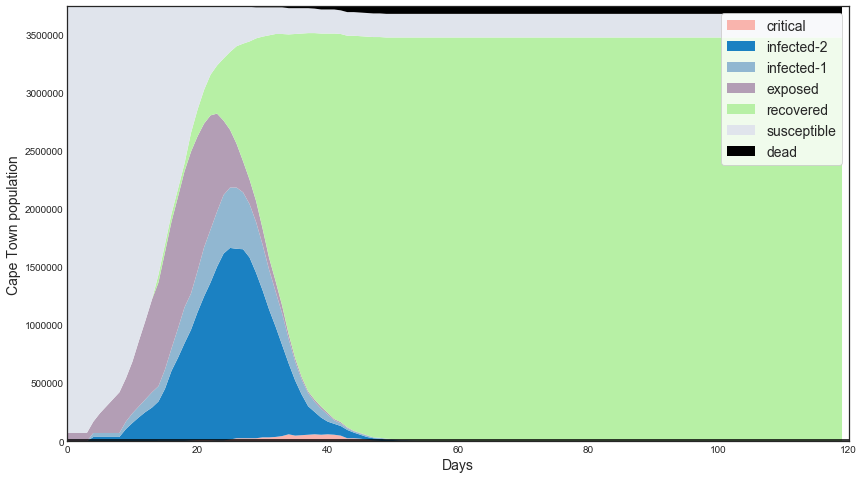

In [40]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical','infected-2', 'infected-1', 'exposed', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, exposed_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b39eb5", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

In [41]:
print('total_deat = ', dead_ot[-1]/ population['Population'].sum())
print('max critical = ', max(critical_ot) / population['Population'].sum())
print('total_infected = ', (dead_ot[-1] + recovered_ot[-1]) / population['Population'].sum())

total_deat =  0.01710261569416499
max critical =  0.01609657947686117
total_infected =  0.9456740442655935


## Draw

In [42]:
pos = nx.spring_layout(infection_states[0])

In [43]:
def plot_model(t):
    network = infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'e':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('purple')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [44]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=119), Output()), _dom_classes=('widget-i…

<function __main__.plot_model(t)>

# Mean Field model

In [43]:
data_folder_mf = 'measurement/meanfield/'
environment_mf = EnvironmentMeanField(0, parameters, districts_data, age_distribution_per_district, distance_matrix)

environment_mf = runner_mean_field(environment_mf, 0, data_folder=data_folder_mf, data_output='network', travel_matrix=travel_matrix)

TypeError: __init__() missing 3 required positional arguments: 'hh_contact_matrix', 'other_contact_matrix', and 'HH_size_distribution'

In [ ]:
len(environment_mf.network.nodes)

### Safe network data

In [34]:
for idx, network in enumerate(environment_mf.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "measurement/meanfield/network_time{}.graphml".format(idx))

### Read data

In [35]:
infection_states_mf = []
for idx in range(parameters["time"]):
    infection_states_mf.append(nx.read_graphml("measurement/meanfield/network_time{}.graphml".format(idx), node_type=int))

In [36]:
susceptible_ot_mf = []
exposed_ot_mf = []
infected_1_ot_mf = []
infected_2_ot_mf = []
critical_ot_mf = []
dead_ot_mf = []
recovered_ot_mf = []

for t in range(parameters['time']):
    network = infection_states_mf[t]
    susceptible = 0
    exposed = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'e':
            exposed += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_mf.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_mf.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_mf.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_mf.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_mf.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_mf.append((recovered / float(len(network)))  * population['Population'].sum())
    exposed_ot_mf.append((exposed / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

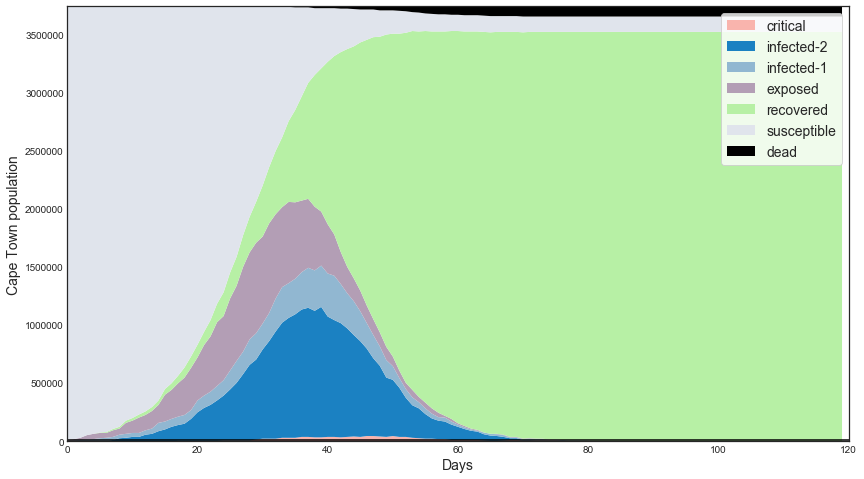

In [37]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical','infected-2', 'infected-1', 'exposed', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_mf, infected_2_ot_mf, infected_1_ot_mf, exposed_ot_mf, recovered_ot_mf, susceptible_ot_mf, dead_ot_mf])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b39eb5", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

Text(0.5, 0, 'Days')

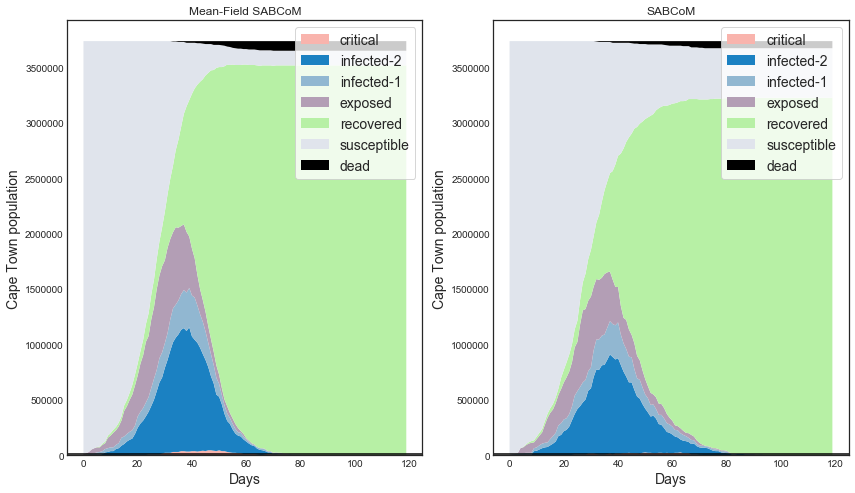

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical','infected-2', 'infected-1', 'exposed', 'recovered', 'susceptible', 'dead']

y1 = np.vstack([critical_ot_mf, infected_2_ot_mf, infected_1_ot_mf, exposed_ot_mf, recovered_ot_mf, susceptible_ot_mf, dead_ot_mf])

ax1.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b39eb5", "#b7f0a5", "#e0e4ec","#000000"]

ax1.stackplot(x, y1, colors= pal, labels=labels)
ax1.legend(loc='best', fontsize='14', frameon=True)
ax1.set_ylabel('Cape Town population', fontsize='14')
ax1.set_xlabel('Days', fontsize='14')
ax1.set_title('Mean-Field SABCoM')

y2 = np.vstack([critical_ot, infected_2_ot, infected_1_ot, exposed_ot, recovered_ot, susceptible_ot, dead_ot])

ax2.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b39eb5", "#b7f0a5", "#e0e4ec","#000000"]

ax2.set_title('SABCoM')
ax2.stackplot(x, y2, colors= pal, labels=labels)
ax2.legend(loc='best', fontsize='14', frameon=True)
ax2.set_ylabel('Cape Town population', fontsize='14')
ax2.set_xlabel('Days', fontsize='14')

In [118]:
columns = ['total dead', 'peak critical', 'total recovered']
experiment_summary = {'1 mean-field surrogate': [dead_ot_mf[-1], max(critical_ot_mf), recovered_ot_mf[-1]],
                  '1 (relative)': [100, 100, 100],
                  '2 SABCoM': [dead_ot[-1], max(critical_ot), recovered_ot[-1]],
                  '2 (relative)': [dead_ot[-1] / dead_ot_mf[-1], max(critical_ot) / max(critical_ot_mf), recovered_ot[-1] / recovered_ot_mf[-1]]
                 }
experiment_summary = pd.DataFrame(experiment_summary).transpose()
experiment_summary.columns = columns

print(experiment_summary.round(2))

                        total dead  peak critical  total recovered
1 mean-field surrogate    41388.67       22575.64       2302715.11
1 (relative)                100.00         100.00           100.00
2 SABCoM                  11287.82       11287.82       2276376.86
2 (relative)                  0.27           0.50             0.99


# Monte Carlo simulations error bars

### 1 Exposed

In [6]:
meanfield_exposed = pd.DataFrame()

for mc in range(parameters["monte_carlo_runs"]):
    meanfield_exposed[mc] = pd.read_csv('C:/Users/joeri/OneDrive/Documents/GitHub/sabcom/measurement/meanfield/seed{}/quantities_state_time.csv'.format(mc))['e']

In [7]:
lower_meanfield_exposed = []
upper_meanfield_exposed = []
for row in range(len(meanfield_exposed)):
    exposed_range = meanfield_exposed.iloc[row]
    lower, upper = confidence_interval(exposed_range, np.mean(exposed_range))
    lower_meanfield_exposed.append(max(lower, 0.0))
    upper_meanfield_exposed.append(upper)

c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [8]:
baseline_exposed = pd.DataFrame()

for mc in range(parameters["monte_carlo_runs"]):
    baseline_exposed[mc] = pd.read_csv('C:/Users/joeri/OneDrive/Documents/GitHub/sabcom/measurement/baseline/seed{}/quantities_state_time.csv'.format(mc))['e']

In [9]:
lower_baseline_exposed = []
upper_baseline_exposed = []
for row in range(len(baseline_exposed)):
    exposed_range = baseline_exposed.iloc[row]
    lower, upper = confidence_interval(exposed_range, np.mean(exposed_range))
    lower_baseline_exposed.append(max(lower, 0.0))
    upper_baseline_exposed.append(upper)

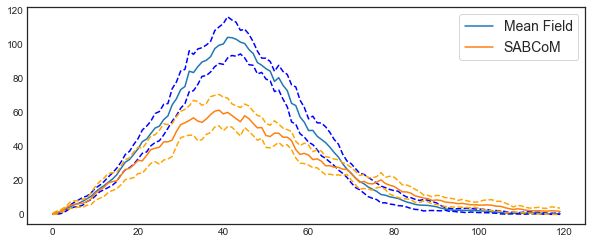

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(meanfield_exposed.index, upper_meanfield_exposed, color='blue', ls='--')
ax1.plot(meanfield_exposed.index, meanfield_exposed.mean(axis=1), label='Mean Field')
ax1.plot(meanfield_exposed.index, lower_meanfield_exposed, color='blue', ls='--')

ax1.plot(baseline_exposed.index, upper_baseline_exposed, color='orange', ls='--')
ax1.plot(baseline_exposed.index, baseline_exposed.mean(axis=1), label='SABCoM')
ax1.plot(baseline_exposed.index, lower_baseline_exposed, color='orange', ls='--')

ax1.legend(loc='best', fontsize='14', frameon=True)

### 2 Critical

In [11]:
meanfield_critical = pd.DataFrame()

for mc in range(parameters["monte_carlo_runs"]):
    meanfield_critical[mc] = pd.read_csv('C:/Users/joeri/OneDrive/Documents/GitHub/sabcom/measurement/meanfield/seed{}/quantities_state_time.csv'.format(mc))['c']

In [12]:
lower_meanfield_critical = []
upper_meanfield_critical = []
for row in range(len(meanfield_critical)):
    critical_range = meanfield_critical.iloc[row]
    lower, upper = confidence_interval(critical_range, np.mean(critical_range))
    lower_meanfield_critical.append(max(lower, 0.0))
    upper_meanfield_critical.append(upper)

In [13]:
baseline_critical = pd.DataFrame()

for mc in range(parameters["monte_carlo_runs"]):
    baseline_critical[mc] = pd.read_csv('C:/Users/joeri/OneDrive/Documents/GitHub/sabcom/measurement/baseline/seed{}/quantities_state_time.csv'.format(mc))['c']

In [14]:
lower_baseline_critical = []
upper_baseline_critical = []
for row in range(len(baseline_critical)):
    critical_range = baseline_critical.iloc[row]
    lower, upper = confidence_interval(critical_range, np.mean(critical_range))
    lower_baseline_critical.append(max(lower, 0.0))
    upper_baseline_critical.append(upper)

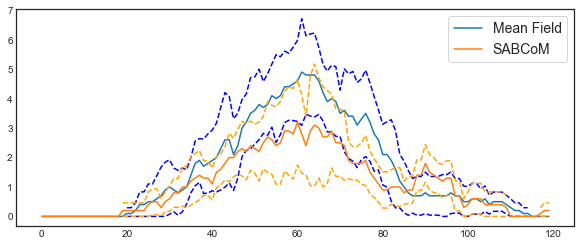

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(meanfield_critical.index, upper_meanfield_critical, color='blue', ls='--')
ax1.plot(meanfield_critical.index, meanfield_critical.mean(axis=1), label='Mean Field')
ax1.plot(meanfield_critical.index, lower_meanfield_critical, color='blue', ls='--')

ax1.plot(baseline_critical.index, upper_baseline_critical, color='orange', ls='--')
ax1.plot(baseline_critical.index, baseline_critical.mean(axis=1), label='SABCoM')
ax1.plot(baseline_critical.index, lower_baseline_critical, color='orange', ls='--')

ax1.legend(loc='best', fontsize='14', frameon=True)

### 3 Dead

In [16]:
meanfield_dead = pd.DataFrame()

for mc in range(parameters["monte_carlo_runs"]):
    meanfield_dead[mc] = pd.read_csv('C:/Users/joeri/OneDrive/Documents/GitHub/sabcom/measurement/meanfield/seed{}/quantities_state_time.csv'.format(mc))['d']

lower_meanfield_dead = []
upper_meanfield_dead = []
for row in range(len(meanfield_dead)):
    dead_range = meanfield_dead.iloc[row]
    lower, upper = confidence_interval(dead_range, np.mean(dead_range))
    lower_meanfield_dead.append(max(lower, 0.0))
    upper_meanfield_dead.append(upper)

In [17]:
baseline_dead = pd.DataFrame()

for mc in range(parameters["monte_carlo_runs"]):
    baseline_dead[mc] = pd.read_csv('C:/Users/joeri/OneDrive/Documents/GitHub/sabcom/measurement/baseline/seed{}/quantities_state_time.csv'.format(mc))['d']
    
lower_baseline_dead = []
upper_baseline_dead = []
for row in range(len(baseline_dead)):
    dead_range = baseline_dead.iloc[row]
    lower, upper = confidence_interval(dead_range, np.mean(dead_range))
    lower_baseline_dead.append(max(lower, 0.0))
    upper_baseline_dead.append(upper)

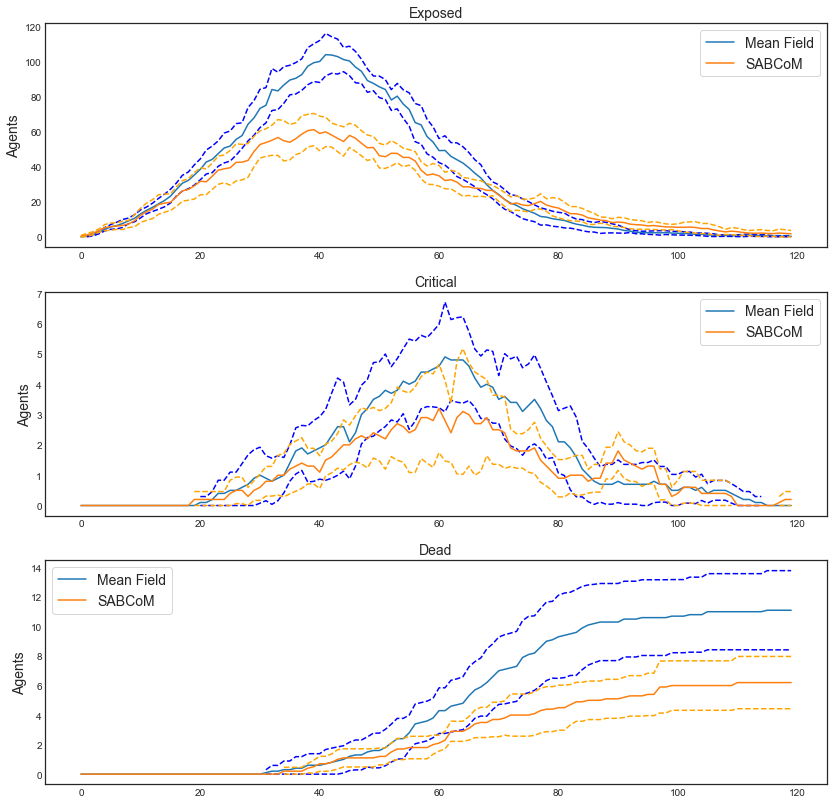

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,14))

ax1.plot(meanfield_exposed.index, upper_meanfield_exposed, color='blue', ls='--')
ax1.plot(meanfield_exposed.index, meanfield_exposed.mean(axis=1), label='Mean Field')
ax1.plot(meanfield_exposed.index, lower_meanfield_exposed, color='blue', ls='--')

ax1.plot(baseline_exposed.index, upper_baseline_exposed, color='orange', ls='--')
ax1.plot(baseline_exposed.index, baseline_exposed.mean(axis=1), label='SABCoM')
ax1.plot(baseline_exposed.index, lower_baseline_exposed, color='orange', ls='--')

ax1.legend(loc='best', fontsize='14', frameon=True)

ax2.plot(meanfield_critical.index, upper_meanfield_critical, color='blue', ls='--')
ax2.plot(meanfield_critical.index, meanfield_critical.mean(axis=1), label='Mean Field')
ax2.plot(meanfield_critical.index, lower_meanfield_critical, color='blue', ls='--')

ax2.plot(baseline_critical.index, upper_baseline_critical, color='orange', ls='--')
ax2.plot(baseline_critical.index, baseline_critical.mean(axis=1), label='SABCoM')
ax2.plot(baseline_critical.index, lower_baseline_critical, color='orange', ls='--')

ax2.legend(loc='best', fontsize='14', frameon=True)

ax3.plot(meanfield_dead.index, upper_meanfield_dead, color='blue', ls='--')
ax3.plot(meanfield_dead.index, meanfield_dead.mean(axis=1), label='Mean Field')
ax3.plot(meanfield_dead.index, lower_meanfield_dead, color='blue', ls='--')

ax3.plot(baseline_dead.index, upper_baseline_dead, color='orange', ls='--')
ax3.plot(baseline_dead.index, baseline_dead.mean(axis=1), label='SABCoM')
ax3.plot(baseline_dead.index, lower_baseline_dead, color='orange', ls='--')

ax3.legend(loc='best', fontsize='14', frameon=True)

titles = ['Exposed', 'Critical', 'Dead']

for idx, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(titles[idx], fontsize='14')
    ax.set_ylabel('Agents', fontsize='14')
    
fig.savefig('meanfield_vs_sabcom.png')

# Run lockdown

In [64]:
# load parameters
with open('parameters/lock_down/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['number_of_agents'] = 1000
parameters['probability_transmission'] = 0.13
parameters['probability_to_travel'] = 0.25

data_folder = 'measurement/lock_down/'
environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)

environment = runner(environment, 0, data_folder=data_folder, data_output='network', travel_matrix=travel_matrix)

In [65]:
for idx, network in enumerate(environment.infection_states):
        for i, node in enumerate(network.nodes):
            network.nodes[i]['agent'] = network.nodes[i]['agent'].status

In [68]:
susceptible_ot_l = []
infected_1_ot_l = []
infected_2_ot_l = []
critical_ot_l = []
dead_ot_l = []
recovered_ot_l = []

for t in range(parameters['time']):
    network = environment.infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_l.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_l.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_l.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_l.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_l.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_l.append((recovered / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

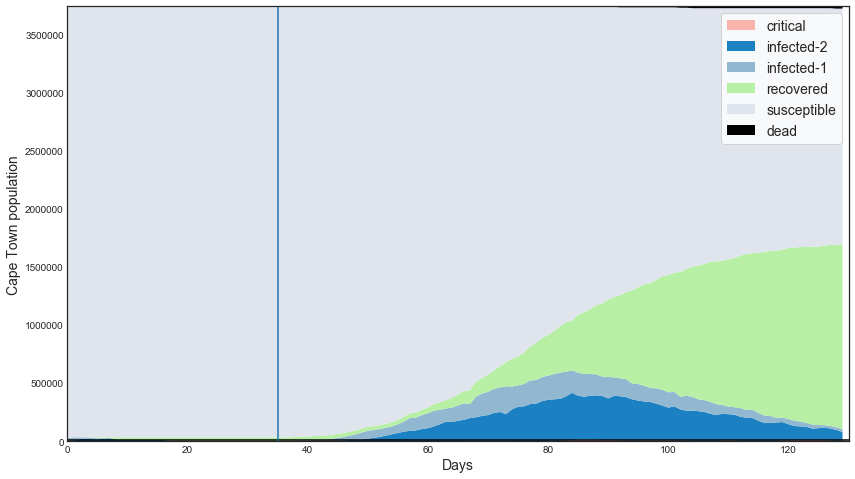

In [71]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_l, infected_2_ot_l, infected_1_ot_l, recovered_ot_l, susceptible_ot_l, dead_ot_l])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

ax.axvline(35)

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

# Inefficient lockdown

In [72]:
# load parameters
with open('parameters/ineffective_lock_down/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['number_of_agents'] = 1000
parameters['probability_transmission'] = 0.13
parameters['probability_to_travel'] = 0.25

data_folder = 'measurement/lock_down/'
environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)

environment = runner(environment, 0, data_folder=data_folder, data_output='network', travel_matrix=travel_matrix)

In [73]:
for idx, network in enumerate(environment.infection_states):
        for i, node in enumerate(network.nodes):
            network.nodes[i]['agent'] = network.nodes[i]['agent'].status

In [74]:
susceptible_ot_li = []
infected_1_ot_li = []
infected_2_ot_li = []
critical_ot_li = []
dead_ot_li = []
recovered_ot_li = []

for t in range(parameters['time']):
    network = environment.infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_li.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_li.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_li.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_li.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_li.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_li.append((recovered / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

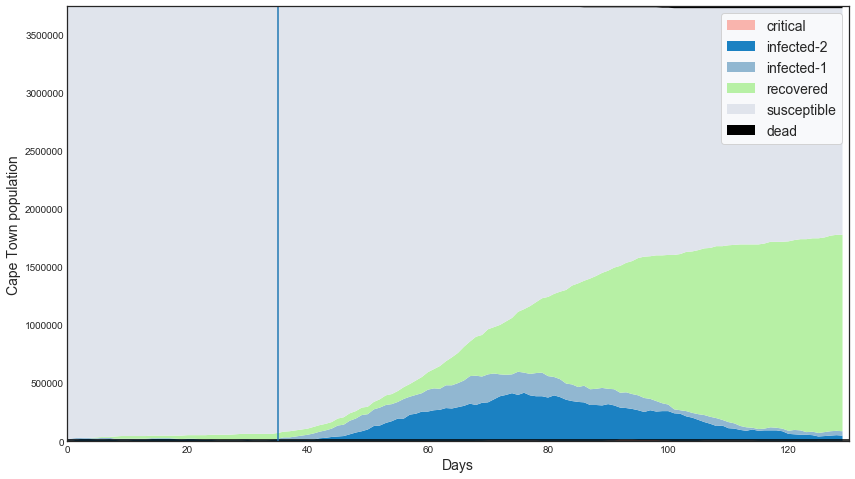

In [75]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_li, infected_2_ot_li, infected_1_ot_li, recovered_ot_li, susceptible_ot_li, dead_ot_li])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

ax.axvline(35)

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

# Elderly lockdown

In [76]:
# load parameters
with open('parameters/lock_down_elderly/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['number_of_agents'] = 1000
parameters['probability_transmission'] = 0.13
parameters['probability_to_travel'] = 0.25

data_folder = 'measurement/lock_down_elderly/'
environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)

environment = runner(environment, 0, data_folder=data_folder, data_output='network', travel_matrix=travel_matrix)

In [77]:
for idx, network in enumerate(environment.infection_states):
        for i, node in enumerate(network.nodes):
            network.nodes[i]['agent'] = network.nodes[i]['agent'].status

In [78]:
susceptible_ot_eli = []
infected_1_ot_eli = []
infected_2_ot_eli = []
critical_ot_eli = []
dead_ot_eli = []
recovered_ot_eli = []

for t in range(parameters['time']):
    network = environment.infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_eli.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_eli.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_eli.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_eli.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_eli.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_eli.append((recovered / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

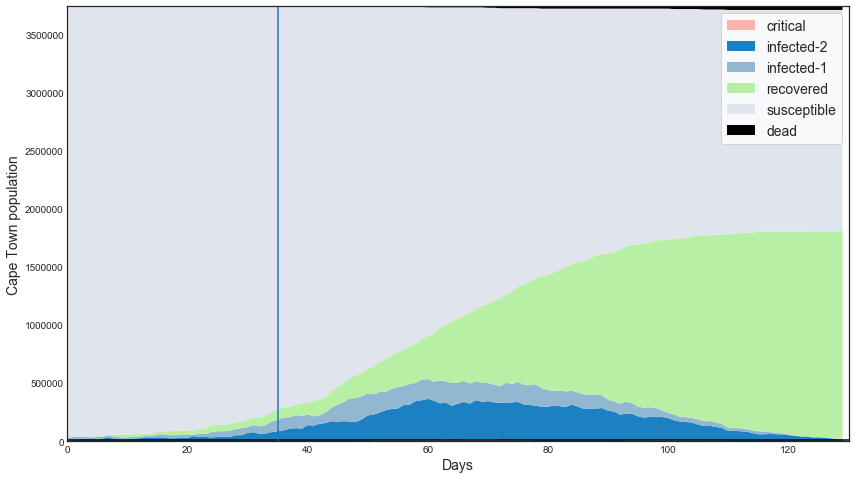

In [79]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_eli, infected_2_ot_eli, infected_1_ot_eli, recovered_ot_eli, susceptible_ot_eli, dead_ot_eli])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

ax.axvline(35)

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

# Tha picture

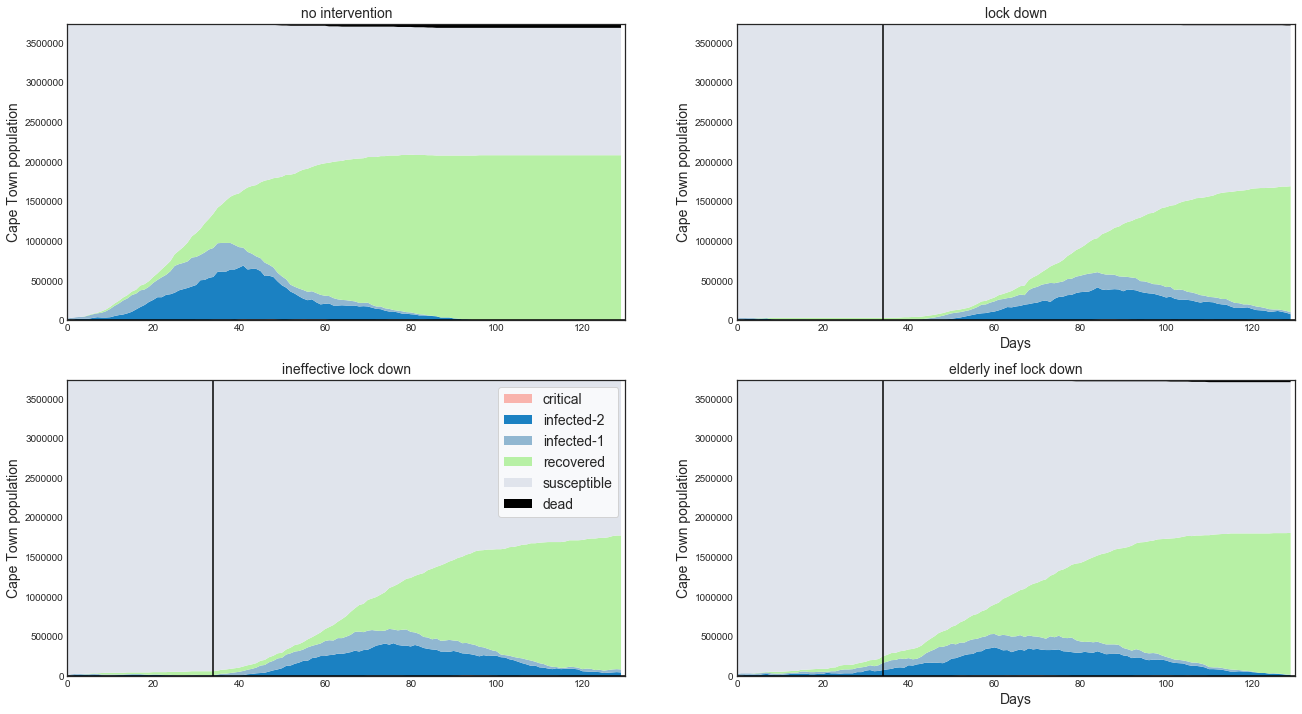

In [84]:
fig, ((ax_base, ax3), (ax, ax4)) = plt.subplots(2, 2, figsize=(22,12))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_li, infected_2_ot_li, infected_1_ot_li, recovered_ot_li, susceptible_ot_li, dead_ot_li])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax.axvline(parameters["lockdown_days"][0], color='black')
ax.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
#ax.set_xlabel('Days', fontsize='14')

ax.set_xlim([0,parameters['time']])
ax.set_ylim([0, population['Population'].sum()])
ax.set_title('ineffective lock down', fontsize='14')

# baseline
y_base = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax_base.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax_base.stackplot(x, y_base, colors= pal, labels=labels)
#ax_base.legend(loc='best', fontsize='14', frameon=True)
ax_base.set_ylabel('Cape Town population', fontsize='14')
#ax_base.set_xlabel('Days', fontsize='14')

ax_base.set_xlim([0,parameters['time']])
ax_base.set_ylim([0, population['Population'].sum()])

ax_base.set_title('no intervention', fontsize='14')

# lockdown
y3 = np.vstack([critical_ot_l, infected_2_ot_l, infected_1_ot_l, recovered_ot_l, susceptible_ot_l, dead_ot_l])

ax3.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax3.axvline(parameters["lockdown_days"][0], color='black')
ax3.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax3.stackplot(x, y3, colors= pal, labels=labels)
#ax3.legend(loc='best', fontsize='14', frameon=True)
ax3.set_ylabel('Cape Town population', fontsize='14')
ax3.set_xlabel('Days', fontsize='14')

ax3.set_xlim([0,parameters['time']])
ax3.set_ylim([0, population['Population'].sum()])
ax3.set_title('lock down', fontsize='14')

# ineffective elderly lockdown
y4 = np.vstack([critical_ot_eli, infected_2_ot_eli, infected_1_ot_eli, recovered_ot_eli, susceptible_ot_eli, dead_ot_eli])

ax4.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax4.axvline(parameters["lockdown_days"][0], color='black')
ax4.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax4.stackplot(x, y4, colors= pal, labels=labels)
#ax4.legend(loc='best', fontsize='14', frameon=True)
ax4.set_ylabel('Cape Town population', fontsize='14')
ax4.set_xlabel('Days', fontsize='14')

ax4.set_xlim([0,parameters['time']])
ax4.set_ylim([0, population['Population'].sum()])
ax4.set_title('elderly inef lock down', fontsize='14')

fig.savefig('measurement/3experiments.png')

# Table

In [81]:
# total dead
columns = ['total dead', 'peak critical', 'total recovered']
experiment_summary = {'1 no intervention': [int(dead_ot[-1]), int(max(critical_ot)), int(recovered_ot[-1])],
                      '1 (relative)': [100, 100, 100],
                      '2 hard lockdown': [int(dead_ot_l[-1]), int(max(critical_ot_l)), int(recovered_ot_l[-1])],
                      '2 (relative)': [dead_ot_l[-1] / dead_ot[-1], max(critical_ot_l) / max(critical_ot), recovered_ot_l[-1] / recovered_ot[-1]],
                      '3 inefficient hard lockdown': [int(dead_ot_li[-1]), int(max(critical_ot_li)), int(recovered_ot_li[-1])],
                      '3 (relative)': [dead_ot_li[-1] / dead_ot[-1], max(critical_ot_li) / max(critical_ot), recovered_ot_li[-1] / recovered_ot[-1]],
                      '4 at risk agents lockdown':[int(dead_ot_eli[-1]), int(max(critical_ot_eli)), int(recovered_ot_eli[-1])],
                      '4 (relative)': [dead_ot_eli[-1] / dead_ot[-1], max(critical_ot_eli) / max(critical_ot), recovered_ot_eli[-1] / recovered_ot[-1]],
                     }

In [82]:
experiment_summary = pd.DataFrame(experiment_summary).transpose()
experiment_summary.columns = columns

In [83]:
experiment_summary.round(2)

,total dead,peak critical,total recovered
1 no intervention,48913.00,18813.0,2084483.00
1 (relative),100.00,100.0,100.00
2 hard lockdown,18813.00,15050.0,1587819.00
2 (relative),0.38,0.8,0.76
3 inefficient hard lockdown,15050.00,15050.0,1689410.00
3 (relative),0.31,0.8,0.81
4 at risk agents lockdown,30100.00,15050.0,1787238.00
4 (relative),0.62,0.8,0.86


# 5 stages of lockdown

In [86]:
# load parameters
susceptible_ot_all = []
infected_1_ot_all = []
infected_2_ot_all = []
critical_ot_all = []
dead_ot_all = []
recovered_ot_all = []

for r in range(5):
    stage = r + 1
    with open('parameters/phases/parameters_phase{}.json'.format(stage)) as json_file:
        parameters = json.load(json_file)

    parameters['number_of_agents'] = 1000
    parameters['probability_transmission'] = 0.13
    parameters['probability_to_travel'] = 0.25

    data_folder = 'measurement/lock_down_elderly/'
    environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)

    environment = runner(environment, 0, data_folder=data_folder, data_output='network', travel_matrix=travel_matrix)

    for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status
                
    susceptible_ot_eli = []
    infected_1_ot_eli = []
    infected_2_ot_eli = []
    critical_ot_eli = []
    dead_ot_eli = []
    recovered_ot_eli = []

    for t in range(parameters['time']):
        network = environment.infection_states[t]
        susceptible = 0
        infected_1 = 0
        infected_2 = 0
        critical = 0
        dead = 0
        recovered = 0
        for idx, node in enumerate(network):
            if network.nodes[idx]['agent'] == 's':
                susceptible += 1
            elif network.nodes[idx]['agent'] == 'i1':
                infected_1 += 1
            elif network.nodes[idx]['agent'] == 'i2':
                infected_2 += 1
            elif network.nodes[idx]['agent'] == 'c':
                critical += 1
            elif network.nodes[idx]['agent'] == 'd':
                dead += 1
            elif network.nodes[idx]['agent'] == 'r':
                recovered +=1
            else:
                print('no status?')

        susceptible_ot_eli.append((susceptible / float(len(network))) * population['Population'].sum())
        infected_1_ot_eli.append((infected_1 / float(len(network))) * population['Population'].sum())
        infected_2_ot_eli.append((infected_2 / float(len(network)))  * population['Population'].sum())
        critical_ot_eli.append((critical / float(len(network)))  * population['Population'].sum())
        dead_ot_eli.append((dead / float(len(network)))  * population['Population'].sum())
        recovered_ot_eli.append((recovered / float(len(network)))  * population['Population'].sum())
        
        susceptible_ot_all.append(susceptible_ot_eli)
        infected_1_ot_all.append(infected_1_ot_eli)
        infected_2_ot_all.append(infected_2_ot_eli)
        critical_ot_all.append(critical_ot_eli)
        dead_ot_all.append(dead_ot_eli)
        recovered_ot_all.append(recovered_ot_eli)

In [88]:
# total dead
columns = ['total dead', 'peak critical', 'total recovered']
experiment_summary = {'0 no intervention': [int(dead_ot[-1]), int(max(critical_ot)), int(recovered_ot[-1])],
                      '0 (relative)': [100, 100, 100],
                      '1 Stage 1': [int(dead_ot_all[0][-1]), int(max(critical_ot_all[0])), int(recovered_ot_all[0][-1])],
                      '1 (relative)': [dead_ot_all[0][-1] / dead_ot[-1], max(critical_ot_all[0]) / max(critical_ot), recovered_ot_all[0][-1] / recovered_ot[-1]],
                      '2 Stage 2': [int(dead_ot_all[1][-1]), int(max(critical_ot_all[1])), int(recovered_ot_all[1][-1])],
                      '2 (relative)': [dead_ot_all[1][-1] / dead_ot[-1], max(critical_ot_all[1]) / max(critical_ot), recovered_ot_all[1][-1] / recovered_ot[-1]],
                      '3 Stage 3':[int(dead_ot_all[2][-1]), int(max(critical_ot_all[2])), int(recovered_ot_all[2][-1])],
                      '3 (relative)': [dead_ot_all[2][-1] / dead_ot[-1], max(critical_ot_all[2]) / max(critical_ot), recovered_ot_all[2][-1] / recovered_ot[-1]],
                      '4 Stage 4': [int(dead_ot_all[3][-1]), int(max(critical_ot_all[3])), int(recovered_ot_all[3][-1])],
                      '4 (relative)': [dead_ot_all[3][-1] / dead_ot[-1], max(critical_ot_all[3]) / max(critical_ot), recovered_ot_all[3][-1] / recovered_ot[-1]],
                      '5 Stage 5':[int(dead_ot_all[4][-1]), int(max(critical_ot_all[4])), int(recovered_ot_all[4][-1])],
                      '5 (relative)': [dead_ot_all[4][-1] / dead_ot[-1], max(critical_ot_all[4]) / max(critical_ot), recovered_ot_all[4][-1] / recovered_ot[-1]],
                     }

In [89]:
experiment_summary = pd.DataFrame(experiment_summary).transpose()
experiment_summary.columns = columns

In [90]:
experiment_summary.round(2)

,total dead,peak critical,total recovered
0 no intervention,48913.00,18813.0,2084483.00
0 (relative),100.00,100.0,100.00
1 Stage 1,18813.00,22575.0,2031807.00
1 (relative),0.38,1.2,0.97
2 Stage 2,18813.00,22575.0,2031807.00
2 (relative),0.38,1.2,0.97
3 Stage 3,18813.00,22575.0,2031807.00
3 (relative),0.38,1.2,0.97
4 Stage 4,18813.00,22575.0,2031807.00
4 (relative),0.38,1.2,0.97
